In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity
from sklearn.cross_decomposition import PLSRegression

In [3]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#d94801','white','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['white','gray']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c']
cml = sns.blend_palette(colors, n_colors=256, as_cmap=True)

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [4]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [5]:
## arrange data
## arrange data for females
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)


male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]



# for female:
m_df= male_df.groupby(['age','uuid']).mean()

In [6]:
#average and normalize female
avg_m_df = m_df.groupby(['age']).mean()
# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

In [7]:
df = m_norm.copy()

In [8]:
pc = PCA(n_components=3)
pcss = pc.fit_transform(df)

In [9]:
pcs = pd.DataFrame(pcss, columns=['PC1','PC2','PC3'])
pcs['age'] = df.index.get_level_values('age')

In [10]:
age_pc = pcs.groupby('age').mean()

In [11]:
variance_explained = pc.explained_variance_ratio_
# Calculate cumulative variance explained by PCs
cumulative_variance_explained = np.cumsum(variance_explained)

In [12]:
print(cumulative_variance_explained)
format_plots()

[0.20780649 0.35299264 0.46340339]


Text(0, 0.5, 'PC2')

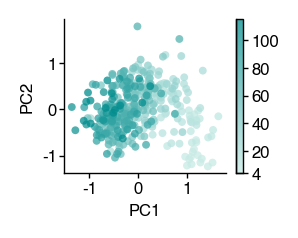

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(1.3,1) 
im = ax.scatter(x=pcs['PC1'], y=pcs['PC2'], 
                cmap=cmm,
                s=8,
                edgecolor='none',
                c=pcs['age'], 
                alpha=0.75,
               )
cb=fig.colorbar(im,ax=ax)

tick_values = [4,20,40,60,80,100]
cb.set_ticks(tick_values)
cb.set_ticklabels([f'{int(tick)}' for tick in tick_values])
# Add more ticks
sns.despine()
#plt.title('female ontogeny')
plt.xlabel('PC1')
plt.ylabel('PC2')

In [14]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ 'PCA_male_norm.pdf')

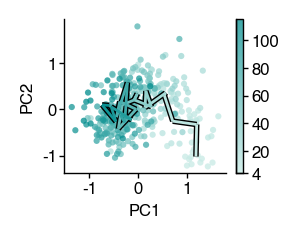

In [21]:

# Create segments for LineCollection
points = np.array([age_pc['PC1'], age_pc['PC2']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object
lc = LineCollection(segments, cmap=cmm, norm=plt.Normalize(0, 1),linewidth=1)
lc.set_array(np.linspace(0, 1, len(age_pc['PC1'])))
# Create the outer black line collection
black_lc = LineCollection(segments, colors='black', linewidth=2)

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1)

# Scatter plot
im = ax.scatter(
    x=pcs['PC1'], y=pcs['PC2'], 
    c=pcs['age'], 
    cmap=cmm,
    #s=8,
    s=5,
    edgecolor='none',
    alpha=0.75,
)

# Add colorbar
cb = fig.colorbar(im, ax=ax)
tick_values = [4,20,40,60,80,100]
cb.set_ticks(tick_values)
cb.set_ticklabels([f'{int(tick)}' for tick in tick_values])


# Add the black line collection to the plot
ax.add_collection(black_lc)

# Add line collection to the plot
ax.add_collection(lc)
ax.autoscale()

# Customize the plot
sns.despine()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [ ]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ 'PCA_male_norm_line.pdf')

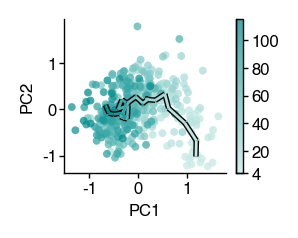

In [29]:
# Create segments for LineCollection
# Convert to DataFrame for easier rolling operation
df = pd.DataFrame(age_pc)

# Apply rolling window average
window_size = 2  # Adjust the window size as needed
df_smooth = df.rolling(window=window_size, min_periods=1, center=True).mean()

# Create segments for LineCollection from the smoothed data
points = np.array([df_smooth['PC1'], df_smooth['PC2']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object
lc = LineCollection(segments, cmap=cmm, norm=plt.Normalize(0, 1),linewidth=1)
lc.set_array(np.linspace(0, 1, len(df_smooth['PC1'])))

# Create the outer black line collection
black_lc = LineCollection(segments, colors='black', linewidth=2)

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1)

# Scatter plot
im = ax.scatter(
    x=pcs['PC1'], y=pcs['PC2'], 
    c=pcs['age'], 
    cmap=cmm,
    #s=8,
    s=8,
    edgecolor='none',
    alpha=0.75,
)

# Add colorbar
cb = fig.colorbar(im, ax=ax)
tick_values = [4,20,40,60,80,100]
cb.set_ticks(tick_values)
cb.set_ticklabels([f'{int(tick)}' for tick in tick_values])


# Add the black line collection to the plot
ax.add_collection(black_lc)

# Add line collection to the plot
ax.add_collection(lc)
ax.autoscale()

# Customize the plot
sns.despine()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [ ]:
#PC1 correlation
from scipy import stats
[cm,pm] = stats.spearmanr(pcs['age'], pcs['PC1'])
print(cm)

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(1.3,1) 
plt.scatter(x=pcs['age'], y=pcs['PC1'], 
            s=8, 
            c=pcs['age'], 
            edgecolor='none',
            #linewidth=0.25,
            #norm='log',
            #alpha=0.75,
            cmap=cmm)
ax = sns.regplot(data=pcs, x='age', y=pcs['PC1'], scatter=False, color='black',
                 logx=True,x_ci='sd',
                )
ax.set(xlabel='age (wks)', ylabel='PC1')
plt.title(f'$\\rho$={cm:0.2f}')
norm = plt.Normalize(pcs['age'].min(), pcs['age'].max())
sns.despine()
sm = plt.cm.ScalarMappable(cmap=cmm, norm=norm)
sm.set_array([])


# Remove the legend and add a colorbar
ax.figure.colorbar(sm)

c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ 'PCA_male_pc1_corr.pdf')

In [ ]:
 ## 3D scatter
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting module
df=m_norm.copy()
pcs3 = PCA(n_components=3).fit_transform(df)
ages =df.index.get_level_values('age')
pc3_df = pd.DataFrame(pcs3, columns=['PC1','PC2','PC3'])
pc3_df['age'] = df.index.get_level_values('age')
age_pc = pc3_df.groupby('age').mean()

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1)
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(pc3_df['PC1'], pc3_df['PC2'], pc3_df['PC3'], c=pc3_df['age'], cmap=cmm, s=2)

# Set custom viewing angles (elevation, azimuthal)
ax.view_init( azim=45)
# Set labels for each axis
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
sns.despine()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import seaborn as sns

# Assuming age_pc is a DataFrame with 'PC1', 'PC2', 'PC3', and 'age' columns
# pcs['PC1'], pcs['PC2'], pcs['PC3'], pcs['age']

# Create segments for Line3DCollection in 3D
points = np.array([age_pc['PC1'], age_pc['PC2'], age_pc['PC3']]).T.reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object for 3D
lc = Line3DCollection(segments, cmap=cmm, norm=plt.Normalize(0, 1), linewidth=1)
lc.set_array(np.linspace(0, 1, len(age_pc['PC1'])))

# Create the outer black line collection for 3D
black_lc = Line3DCollection(segments, colors='black', linewidth=2)

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.set_size_inches(2, 1.7)

# Scatter plot in 3D
im = ax.scatter(
    xs=pcs['PC1'], ys=pcs['PC2'], zs=pcs['PC3'],
    c=pcs['age'], cmap=cmm,
    s=4, edgecolor='none'
)

# Add colorbar
cb = fig.colorbar(im, ax=ax)
tick_values = [4, 20, 40, 60, 80, 100]
cb.set_ticks(tick_values)
cb.set_ticklabels([f'{int(tick)}' for tick in tick_values])

# Add the black line collection to the plot
ax.add_collection3d(black_lc)

# Add line collection to the plot
ax.add_collection3d(lc)
ax.autoscale()

# Customize the plot
sns.despine()
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()


In [ ]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ 'PCA_male_pc1__3d.pdf')